In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 465 kB 47.8 MB/s 


In [ ]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import requests
import json
import re
import os
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
from konlpy.tag import Okt
from konlpy.tag import Mecab
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [ ]:
total = pd.read_csv('DataBlind.csv') # 널값 확인
total.info
#total = total[total['review'].notnull()]
X = total['review']
Y = total['label']

In [ ]:
X_input = total[(total['enter'] == 'naver')]
X_input

In [ ]:
# X, Y train / test split
from sklearn.model_selection import train_test_split
#8:2 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, stratify=Y, random_state = 0)


In [ ]:
# 토큰화  N-gram 을 해주는 함수
def preprocessing(review):   
    okt = Okt()    
    
    f = open('stward.txt')
    stop_words = f.read().split()  
    review_text = re.sub("[^가-힣\\s]", "", review)  
    word_review = okt.pos(review_text, stem=True)   
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words and len(token) > 1]   
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']] 
    
    n_gram = [' '.join(word_review[i:i+2]) for i in range(len(word_review)-1)]
     
    word_review += n_gram
    
    return word_review

In [ ]:
#Tf-Idf 벡터화
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#벡터화 , Tfidf 
tfidf = TfidfVectorizer(tokenizer=preprocessing, max_features=2000, min_df=5, max_df=0.5) #의미 , 최소갯수, 단어장에 포함되기 위한 최대빈도

X_train_tfidf = tfidf.fit_transform(X_train) #문제집

X_test_tfidf = tfidf.transform(X_test) #시험지
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#로지스틱 리그레션 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#blind_log 이라는 변수에 LogisticRegression 모델을 생성한 후 train데이터로 학습
blind_log = LogisticRegression(random_state = 0, C=1) #c(overfit=규제화 0.1 강화 / underfit = 규제화 10 약화)
blind_log.fit(X_train_tfidf, Y_train)
print('Train set score: {:.3f}'.format(blind_log.score(X_train_tfidf, Y_train)))   
print('Test set score: {:.3f}'.format(blind_log.score(X_test_tfidf, Y_test)))

Train set score: 0.928
Test set score: 0.914


오차행렬:
 [[1823  137]
 [ 201 1759]]
정확도:   0.9137755102040817
정밀도:   0.9277426160337553
재현율:   0.8974489795918368
F1 스코어:    0.9123443983402489
ROC_AUC:  0.9699120158267388


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


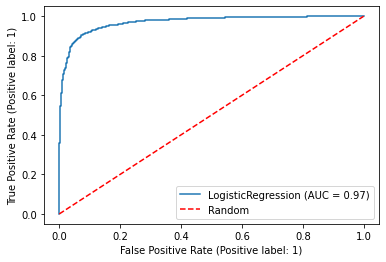

In [ ]:
# 앞서 소개한 분류 평가지표로 모델을 다시 평가해보자.
# 먼저 0과 1 클래스의 비율이 동일한 데이터셋으로 학습한 모델을 평가해보자.
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score

# roc_auc는 예측 클래스값이 아닌 예측 확률값을 기반으로 계산되므로 positive(1)로 예측할 확률값인 pred_proba 변수를 생성해준다.
pred = blind_log.predict(X_test_tfidf)
pred_proba = blind_log.predict_proba(X_test_tfidf)[:,1]
print('오차행렬:\n', confusion_matrix(Y_test, pred))
print('정확도:  ', accuracy_score(Y_test, pred))
print('정밀도:  ', precision_score(Y_test, pred))
print('재현율:  ', recall_score(Y_test, pred))
print('F1 스코어:   ', f1_score(Y_test, pred))
print('ROC_AUC: ', roc_auc_score(Y_test, pred_proba))
plot_roc_curve(blind_log, X_test_tfidf, Y_test)
plt.plot([0, 1], [0, 1], 'r--', label='Random') # 가운데 대각선 직선
plt.legend()
plt.show()

In [ ]:
#랜덤포레스트

from sklearn.ensemble import RandomForestClassifier

blind_rf = RandomForestClassifier(n_estimators = 100, max_depth=30, random_state = 0)   # 결정트리(나무100개) 100개 / 하나의 트리의 길이는(deep깊이) 30 
blind_rf.fit(X_train_tfidf, Y_train)
print('Train set score: {:.3f}'.format(blind_rf.score(X_train_tfidf, Y_train)))
print('Test set score: {:.3f}'.format(blind_rf.score(X_test_tfidf, Y_test)))

Train set score: 0.918
Test set score: 0.865


In [ ]:
#그래디언부스팅 
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_tfidf, Y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_tfidf, Y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test_tfidf, Y_test)))

brt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train_tfidf, Y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_tfidf, Y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test_tfidf, Y_test)))

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.1)
gbrt.fit(X_train_tfidf, Y_train)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train_tfidf, Y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test_tfidf, Y_test)))

훈련 세트 정확도: 0.853
테스트 세트 정확도: 0.837
훈련 세트 정확도: 0.853
테스트 세트 정확도: 0.837
훈련 세트 정확도: 0.853
테스트 세트 정확도: 0.837


In [ ]:
#모델핸들링 성능향상
import pickle
from google.colab import drive

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

In [ ]:
#분류모델 담을 리스트 생성
classifiers = []
#랜덤스테이트 2설정
random_state = 2
#데이터프레임 생성을 위하여 알고리즘 제목 저장
clf_names = ['Random Forest','Gradient Boost', 'Logistic Regression','Support Vector' ]
#트리기반 알고리즘
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
#선형 알고리즘
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state=random_state))


In [ ]:
#레이블인코딩된 데이터로 교차검증을 수행하여 리스트에 저장
# 보통 kfold를 4개로 주거나 딱떨어지게 준다.
kfold = StratifiedKFold(n_splits=10) #n_splits = 10 10번의 교차 검증을 시행하겠다.

cv_results = []
for classifier in classifiers : #크로스 벨리션 스코어를 실행 #교차검증 10번시키고 학습 -> 검증
    cv_results.append(cross_val_score(classifier, X_train_tfidf, y = Y_train,
                                      scoring = "accuracy", cv = kfold, n_jobs=4)) #엔잡은 씨피유몇개


In [ ]:
 # 교차검증 점수 리스트 출력 #리스트를 보면 이 결과가 array가 1개의 개념 
# 각각 모델의 결과
# array가 10개의 cross_val_score
cv_results

[array([0.87882653, 0.86798469, 0.87372449, 0.88711735, 0.8807398 ,
        0.86543367, 0.8787492 , 0.88704531, 0.87364391, 0.87938736]),
 array([0.83035714, 0.8252551 , 0.82844388, 0.84757653, 0.84183673,
        0.83673469, 0.83599234, 0.85003191, 0.83535418, 0.84492661]),
 array([0.89604592, 0.89923469, 0.90561224, 0.91964286, 0.91709184,
        0.88520408, 0.90491385, 0.91831525, 0.9074665 , 0.90938098]),
 array([0.89413265, 0.90242347, 0.91262755, 0.9247449 , 0.91517857,
        0.89158163, 0.91065731, 0.92661136, 0.91384812, 0.91448628])]

In [ ]:
# 첫 번째 모델 랜덤포레스트의 평균 교차검증 점수 출력
cv_results[0].mean()

0.8772652312360808

In [ ]:
# 첫 번째 모델(Decision Tree Classifier)의 교차검증 점수 표준편차 출력
cv_results[0].std()

0.006824184728240763

In [ ]:
# 모델들의 교차검증 점수의 평균과 표준편차를 계산하여 리스트에 저장
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [ ]:
#데이터프레임으로 변환
results_le = pd.DataFrame(cv_results, index=clf_names)
results_le

,0,1,2,3,4,5,6,7,8,9
Random Forest,0.878827,0.867985,0.873724,0.887117,0.880740,0.865434,0.878749,0.887045,0.873644,0.879387
Gradient Boost,0.830357,0.825255,0.828444,0.847577,0.841837,0.836735,0.835992,0.850032,0.835354,0.844927
Logistic Regression,0.896046,0.899235,0.905612,0.919643,0.917092,0.885204,0.904914,0.918315,0.907466,0.909381
Support Vector,0.894133,0.902423,0.912628,0.924745,0.915179,0.891582,0.910657,0.926611,0.913848,0.914486


In [ ]:
# 모델별 교차검증 점수 평균, 표준편차를 새로운 칼럼으로 추가
results_le['mean'] = cv_means
results_le['std'] = cv_std

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


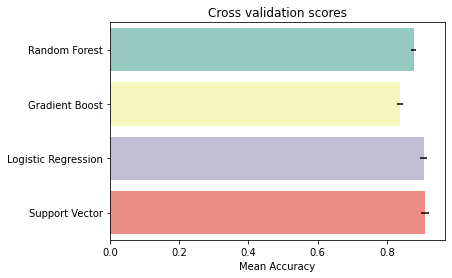

In [ ]:
#  모델별 교자검증 점수 평균 시각화
g = sns.barplot("mean",results_le.index ,data = results_le, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
results_le.T

,Random Forest,Gradient Boost,Logistic Regression,Support Vector
0,0.878827,0.830357,0.896046,0.894133
1,0.867985,0.825255,0.899235,0.902423
2,0.873724,0.828444,0.905612,0.912628
3,0.887117,0.847577,0.919643,0.924745
4,0.880740,0.841837,0.917092,0.915179
5,0.865434,0.836735,0.885204,0.891582
6,0.878749,0.835992,0.904914,0.910657
7,0.887045,0.850032,0.918315,0.926611
8,0.873644,0.835354,0.907466,0.913848
9,0.879387,0.844927,0.909381,0.914486


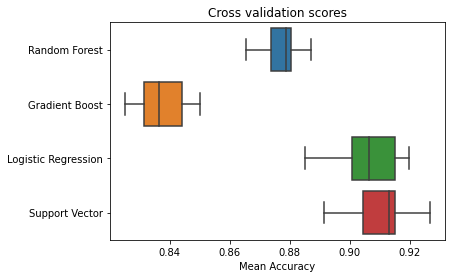

In [ ]:
# 모델별 교차검증 점수 시각화
results1 = results_le.drop(['mean', 'std'], axis=1)
g = sns.boxplot(data=results1.T, orient='h')
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [ ]:
#하이퍼 파라미터 - 1
# Random Forest 객체 생성
RFC = RandomForestClassifier(random_state=7)


# param_grid 설정
rf_param_grid = {"max_depth": [10,20,30],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300,500],
              "criterion": ["gini"]}

# Grid Search 객체 생성
#param_grid 
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsRFC.fit(X_train_tfidf,Y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=7), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=1)

In [ ]:
# 최적의 파라미터 조합 출력
RFC_best = gsRFC.best_estimator_
print(RFC_best)

# 최고 점수(accuracy) 출력
print(gsRFC.best_score_)


RandomForestClassifier(bootstrap=False, max_depth=30, n_estimators=300,
                       random_state=7)
0.8626571799747339


In [ ]:
#Support Vector 객체 생성
#비활률적모형 서포트백터머신

SVM = SVC(random_state=7, probability=True)

# param_grid 설정
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

# Gradient boost 객체 생성
gsSVM = GridSearchCV(SVM,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsSVM.fit(X_train_tfidf,Y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [ ]:
# 최적의 파라미터 조합 출력
SVM_best = gsSVM.best_estimator_
print(SVM_best)

# 최고 점수(accuracy) 출력
print(gsSVM.best_score_)


In [ ]:
# Logistic Regression 객체 생성
LGS = LogisticClassifier(random_state=7)

# param_grid 설정
lgs_param_grid = {'penalty': ['l1','l2'], 
                  'C': np.logspace(0,4,10)}

# Gradient boost 객체 생성
gsLGS = GridSearchCV(LGS,param_grid = lgs_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsLGS.fit(X_train_tfidf,Y_train)

In [ ]:
# 최적의 파라미터 조합 출력
LGS_best = gsLGS.best_estimator_
print(LGS_best)

# 최고 점수(accuracy) 출력
print(gsLGS.best_score_)
